In [ ]:
!pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/imageprocessing')

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import pydicom


plt.set_cmap('gray')
%matplotlib inline

# Seeding
seed = 2019
random.seed(seed)
np.random.seed(seed)

IMG_DTYPE = np.float64
SEG_DTYPE = np.uint8

<Figure size 640x480 with 0 Axes>

In [ ]:
masks_path = os.path.join('train', 'masks')
training_path = os.path.join('train', 'patients')

In [ ]:
def show_image(*args, **kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title = kwargs.get('title', '')
    if len(args) == 0:
        raise ValueError("No images given to show_image")
    elif len(args) == 1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n = len(args)
        if type(cmap) == str:
            cmap = [cmap] * n
        if type(title) == str:
            title = [title] * n
        plt.figure(figsize=(n * 5, 10))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.axis('off')
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

def normalize_img(img):
    """ Normalize image values to [0,1] """
    min_val, max_val = float(np.min(img)), float(np.max(img))
    return (img - min_val) / (max_val - min_val)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [ ]:
def preprocess_img_slice(img_slc):

    img_slc[img_slc > 1200] = 0
    img_slc = np.clip(img_slc, -100, 400)
    img_slc = normalize_img(img_slc)

    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_img(img_slc)
    return img_slc

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        tumor_volume = None

        image_path = os.path.join(self.path, "patients", id_name)
        mask_path = os.path.join(self.path, "masks")
        dicom_image = pydicom.dcmread(image_path)

        image = preprocess_img_slice(dicom_image.pixel_array)

        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array

        image = np.multiply(image, np.clip(liver_mask, 0, 1))

        image = np.array(Image.fromarray(image).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path, 'merged_livertumors', id_name+'.jpg'))

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = mask // 255

        mask = mask[:, :, np.newaxis]

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        files_batch = self.ids[index * self.batch_size: (index + 1) * self.batch_size]
        image = []
        mask = []
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,) * 3, axis=-1)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [ ]:
image_size = 256
train_path = "train"
batch_size = 8
epochs = 30

# Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
    images.append(file)

# Randomly select 25% of the data
selected_ids = random.sample(images, int(0.25 * len(images)))

# Divide into training and validation sets
val_data_size = len(selected_ids) // 5
valid_ids = selected_ids[:val_data_size]
train_ids = selected_ids[val_data_size:]

print(len(train_ids))

4654


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)

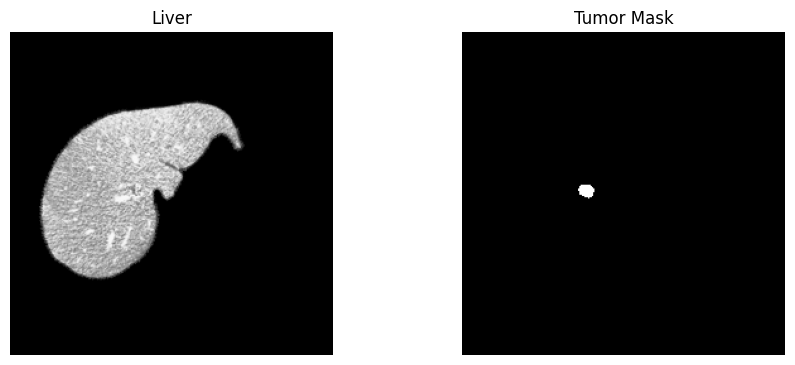

In [ ]:
random_index = random.randint(0, len(x) - 1)
random_index = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot Liver Image
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[random_index])
ax.set_title("Liver")
ax.axis('off')

# Plot Mask Image
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[random_index], (image_size, image_size)), cmap="gray")
ax.set_title("Tumor Mask")
ax.axis('off')

plt.show()


#Visualizing results and confusion matrix for tumor segmentation from extracted ROI (segmented liver)

In [ ]:
model = keras.models.load_model(os.path.join('models','tumor_model_25percent.h5'), compile= False)

In [ ]:
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

1/1 [==============================] - 12s 12s/step


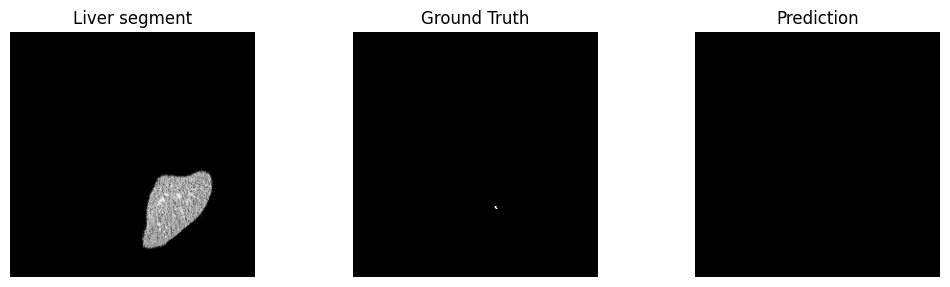

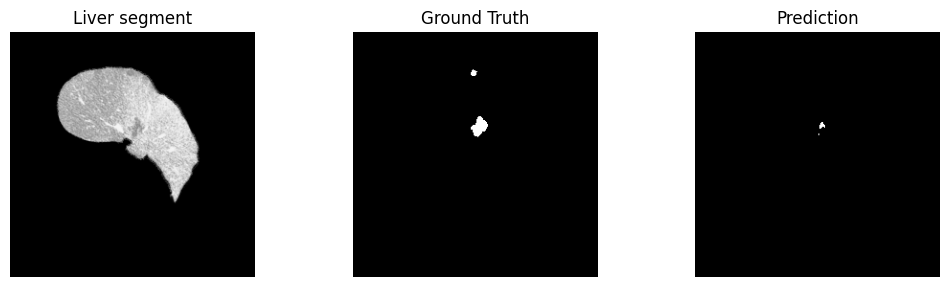

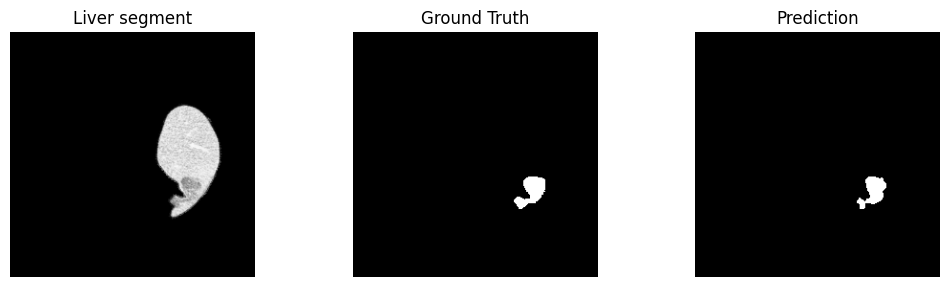

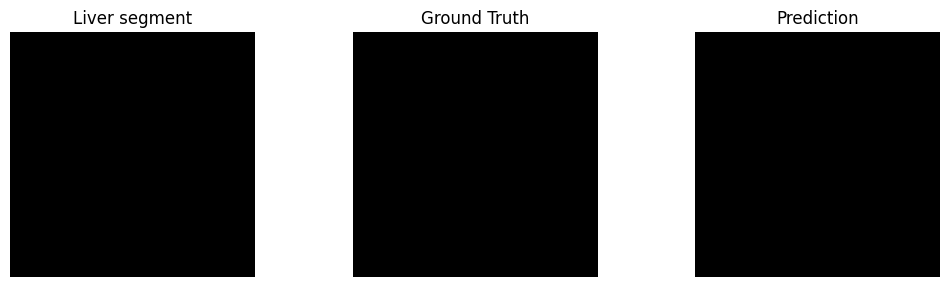

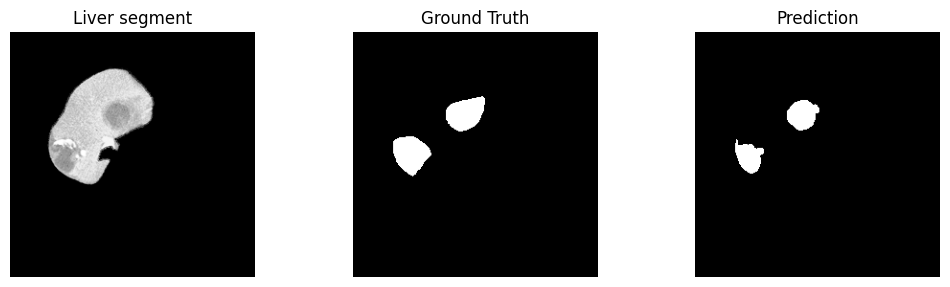

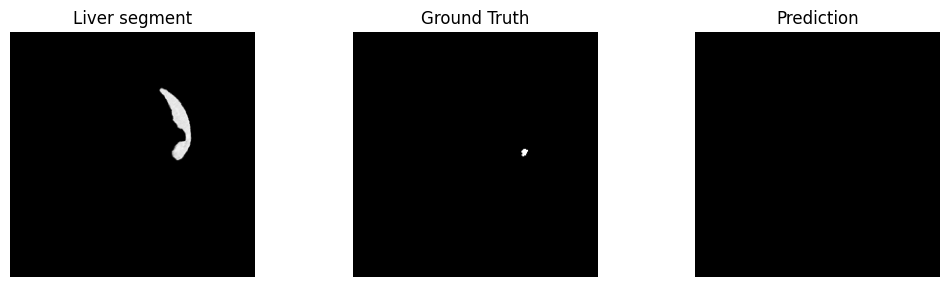

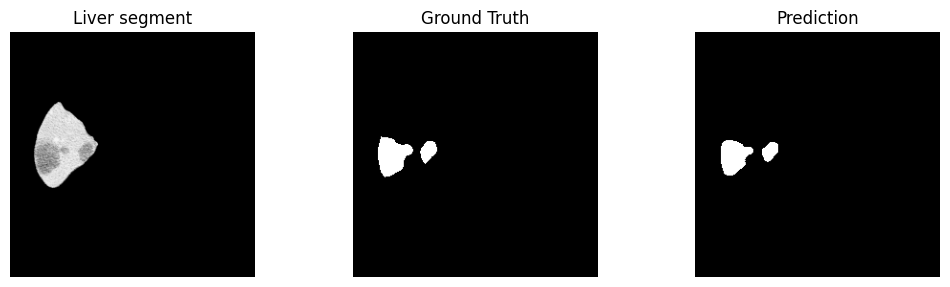

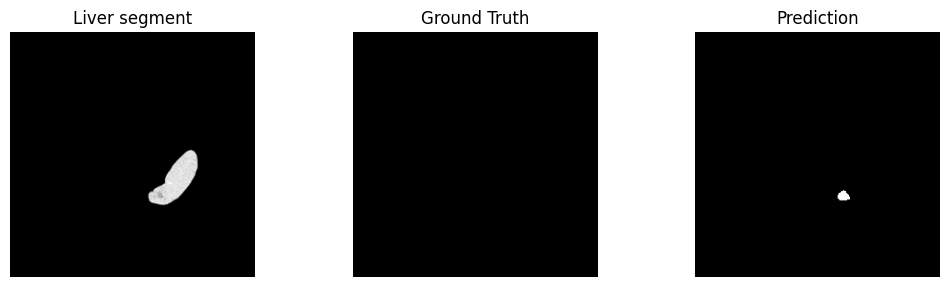

1/1 [==============================] - 6s 6s/step


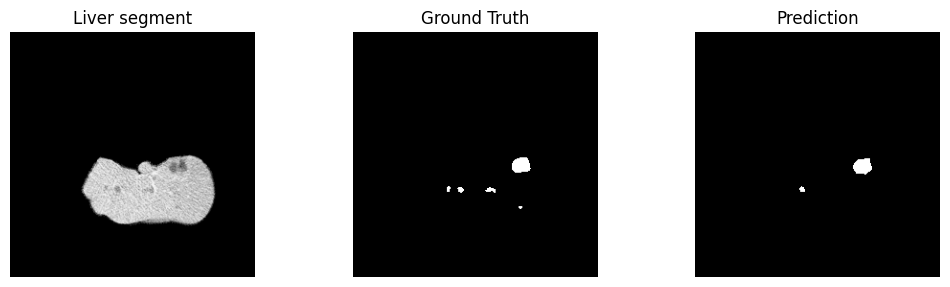

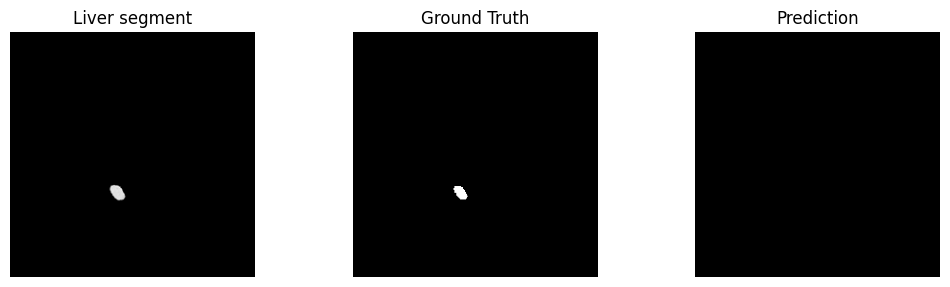

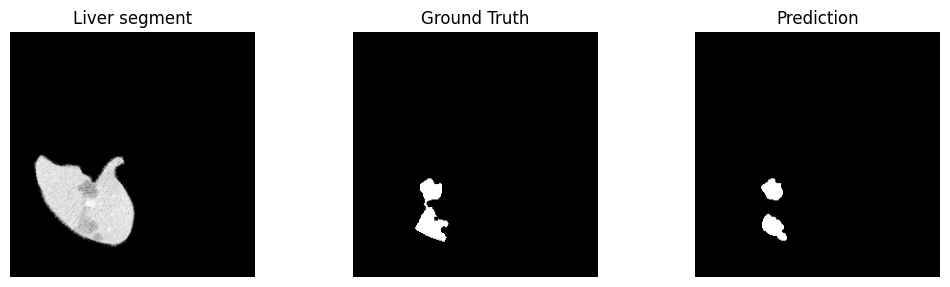

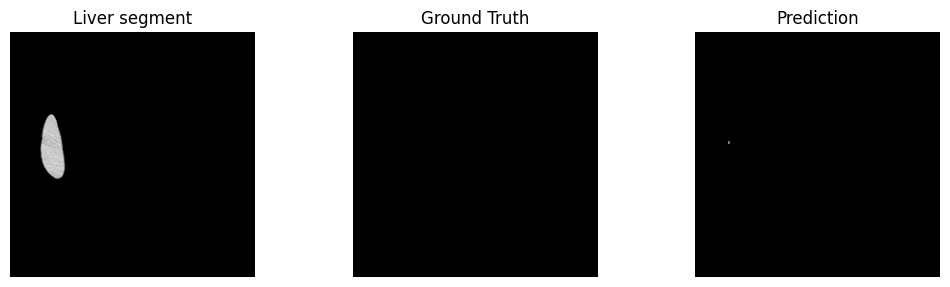

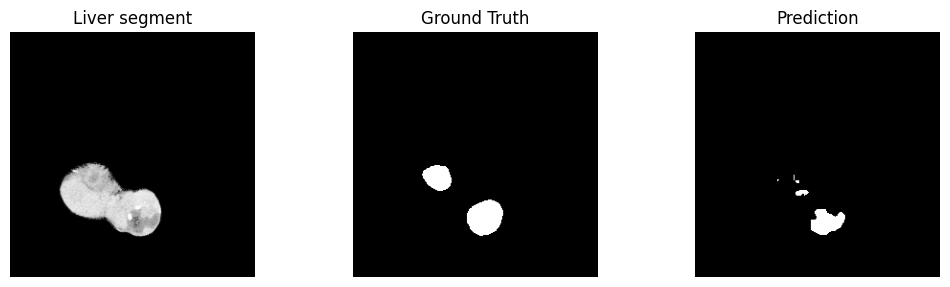

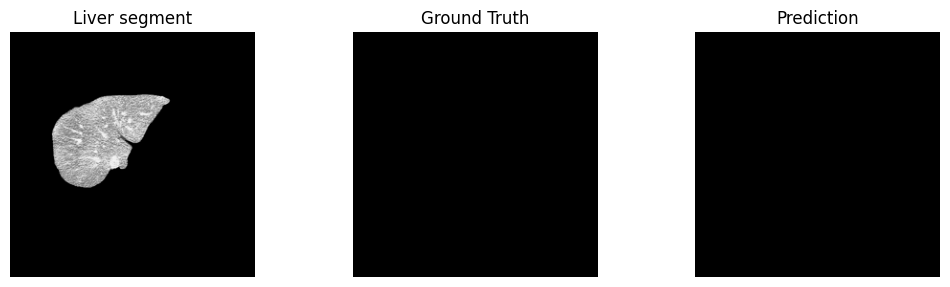

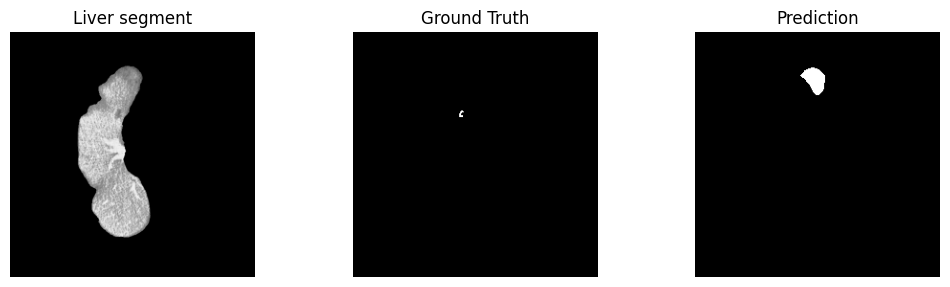

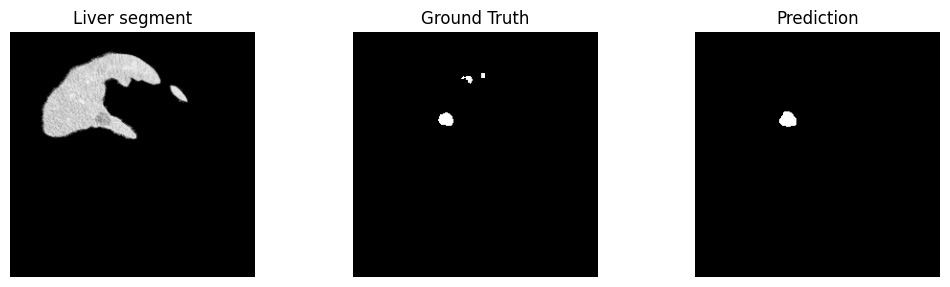

1/1 [==============================] - 4s 4s/step


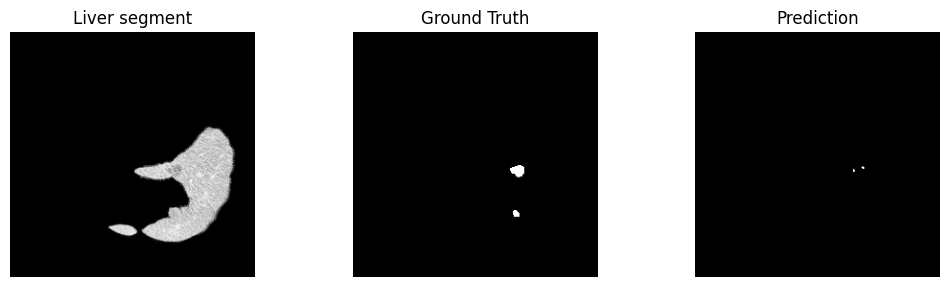

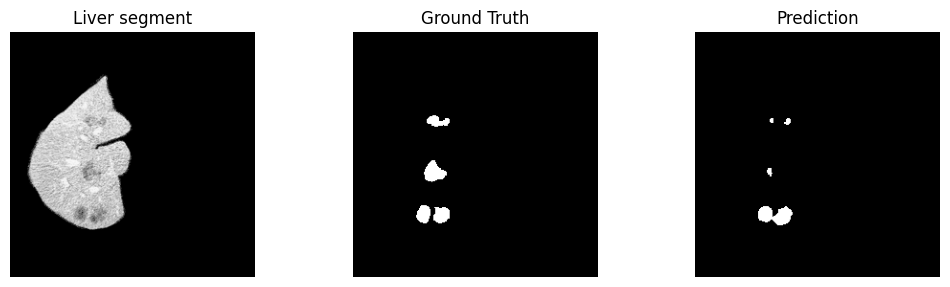

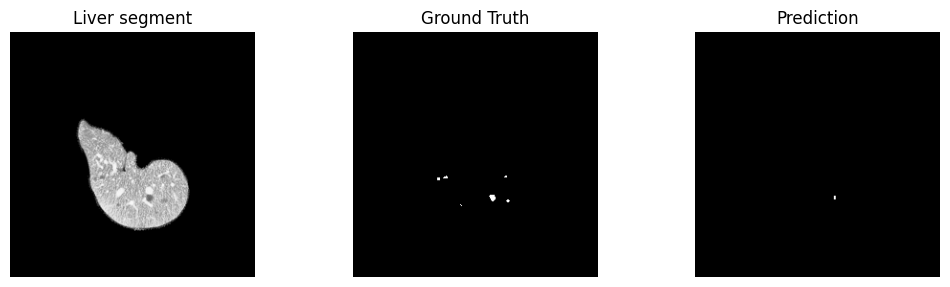

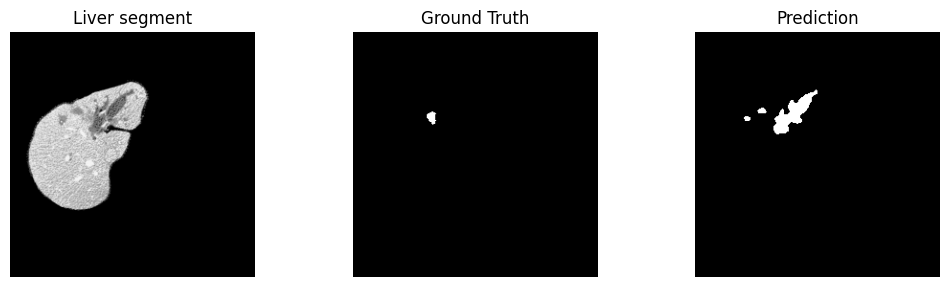

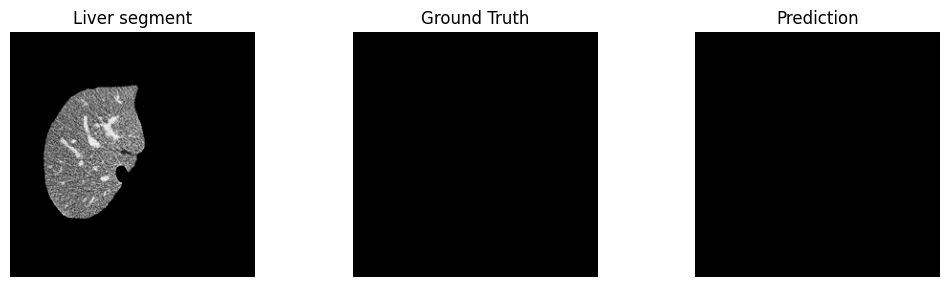

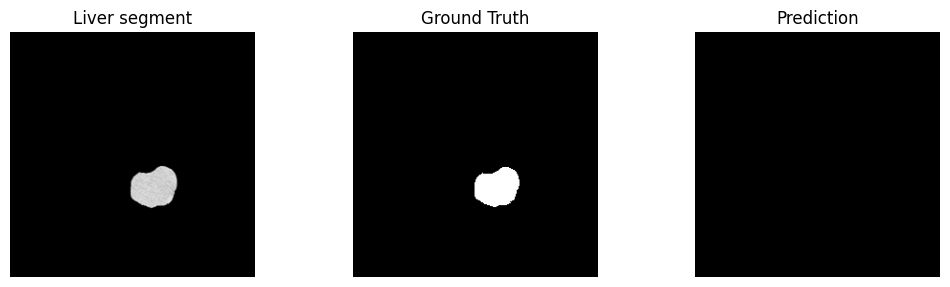

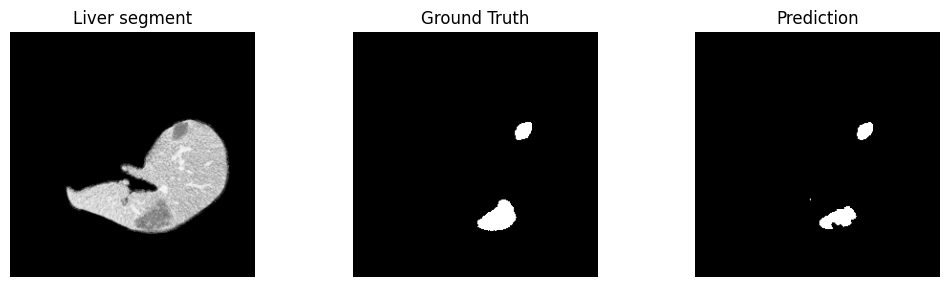

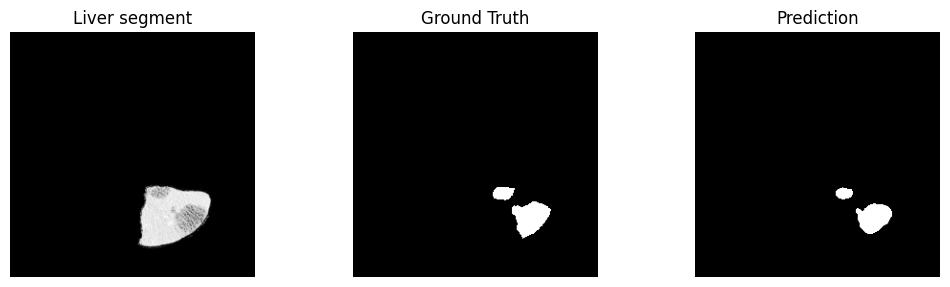

1/1 [==============================] - 6s 6s/step


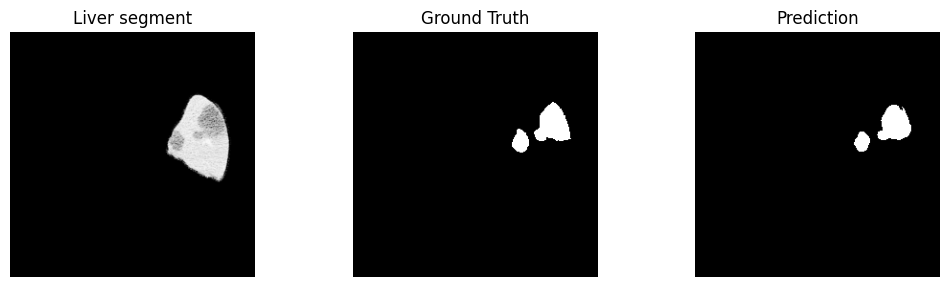

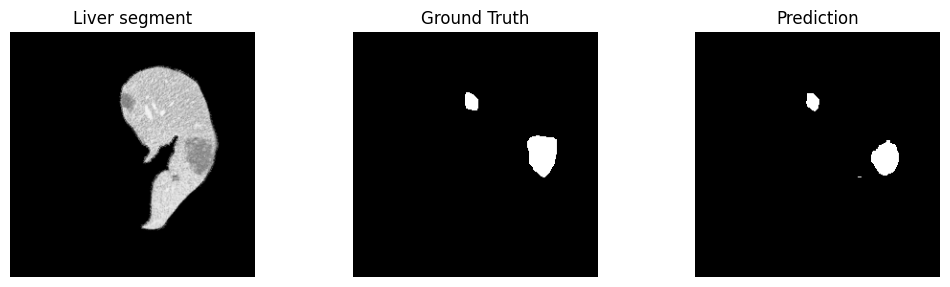

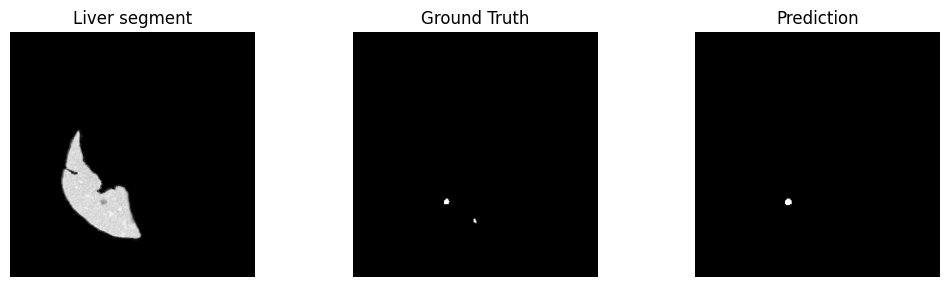

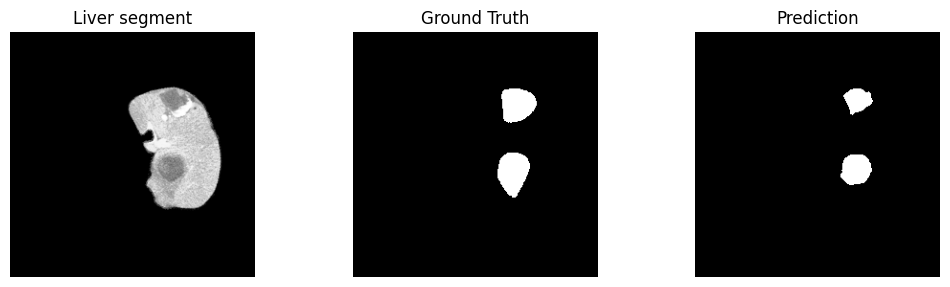

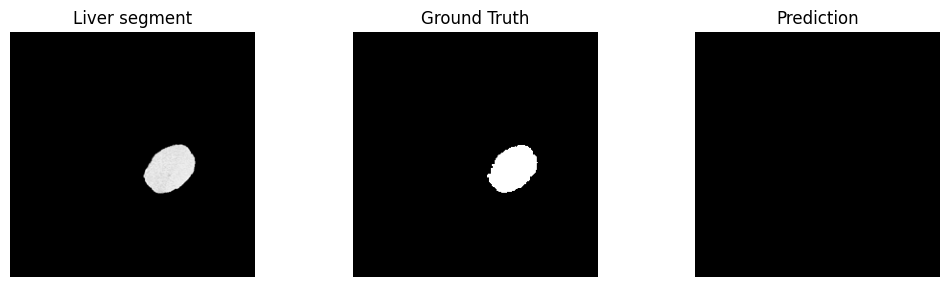

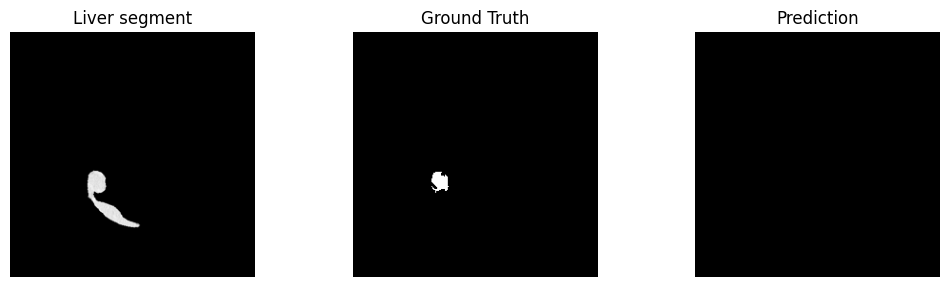

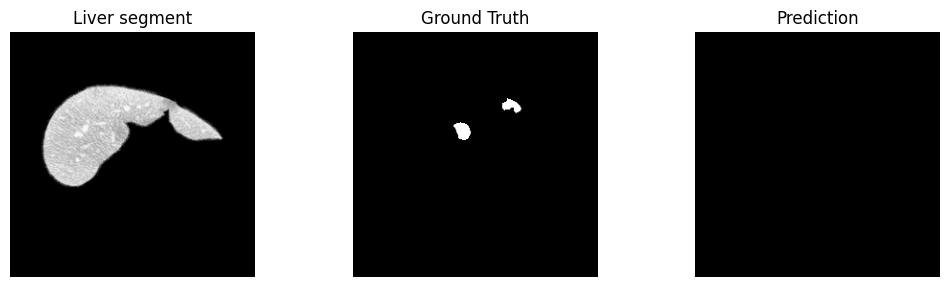

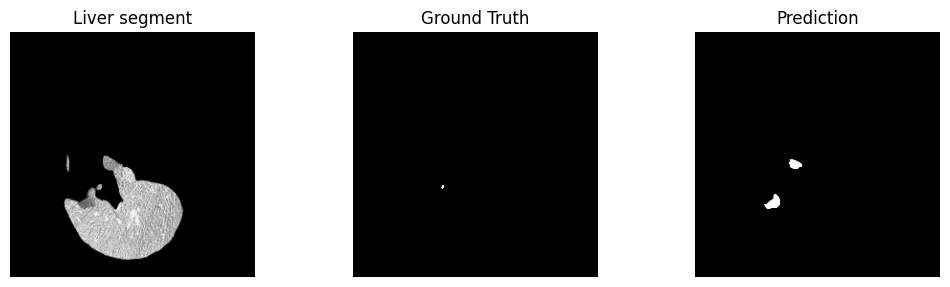

In [ ]:
for i in range(1, 5, 1):
    # Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.8

    for j in range(len(result)):
        fig = plt.figure(figsize=(12, 10))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(x[j], cmap="gray")
        ax.axis('off')
        ax.set_title("Liver segment")

        ax = fig.add_subplot(1, 3, 2)
        ax.imshow(np.clip(np.reshape(y[j] * 255, (image_size, image_size)), 0, 255), cmap="gray")
        ax.axis('off')
        ax.set_title("Ground Truth")

        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.clip(np.reshape(result[j] * 255, (image_size, image_size)), 0, 255), cmap="gray")
        ax.axis('off')
        ax.set_title("Prediction")

        plt.show()  # Display the current figure

plt.close('all')


1/1 [==============================] - 5s 5s/step


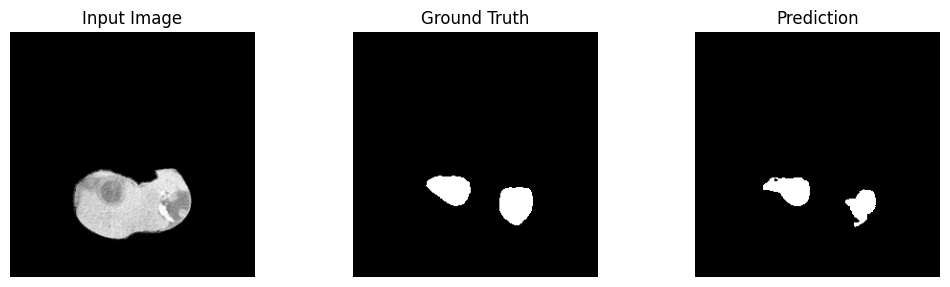

IoU: 0.71%
Pixel Accuracy: 98.98%
True Positive Accuracy: 73.41%
Dice Coefficient: 0.8274


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

random_batch = 6
random_sample = 4

x, y = valid_gen.__getitem__(random_batch)
result = model.predict(x)
result = result > 0.5

# Display the input image, Ground Truth, and Prediction in one line
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
fig.subplots_adjust(wspace=0.4)

# Display the input image
ax1.imshow(x[random_sample], cmap="gray")
ax1.axis('off')
ax1.set_title("Input Image")

# Display the Ground Truth
ax2.imshow(np.reshape(y[random_sample] * 255, (image_size, image_size)), cmap="gray")
ax2.axis('off')
ax2.set_title("Ground Truth")

# Display the Prediction
ax3.imshow(np.reshape(result[random_sample] * 255, (image_size, image_size)), cmap="gray")
ax3.axis('off')
ax3.set_title("Prediction")
plt.show()


# Calculate confusion matrix and metrics
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

pixel_accuracy = (cm[3] + cm[0]) / (cm[3] + cm[0] + cm[1] + cm[2]) * 100
true_positive_accuracy = (cm[3]) / (cm[3] + cm[2]) * 100
dice_coefficient = dice(y[random_sample], result[random_sample])
iou = cm[3] / (cm[3] + cm[1] + cm[2])

print("IoU: {:.2f}%".format(iou)) #Intersection over union
print("Pixel Accuracy: {:.2f}%".format(pixel_accuracy))
print("True Positive Accuracy: {:.2f}%".format(true_positive_accuracy))
print("Dice Coefficient: {:.4f}".format(dice_coefficient))


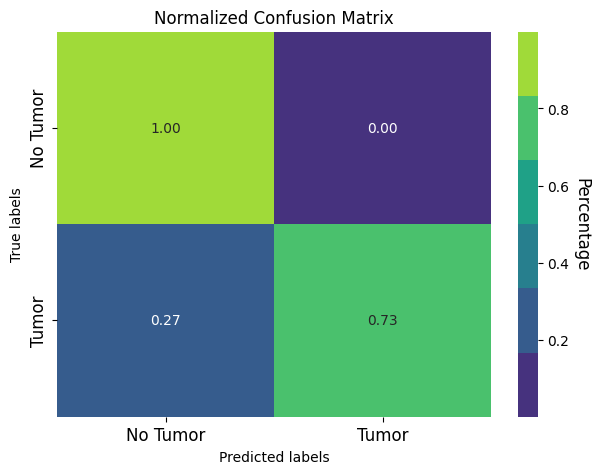

In [ ]:
import seaborn as sns

# Normalize the confusion matrix
cm_2d_normalized = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]

# Set the color map
cmap = sns.color_palette("viridis")

# Plot the normalized confusion matrix
plt.figure(figsize=(7, 5))
ax = plt.subplot()

sns.heatmap(cm_2d_normalized, annot=True, fmt=".2f", cmap=cmap, cbar=True, ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

cbar = ax.collections[0].colorbar
cbar.set_label('Percentage', rotation=270, labelpad=15, fontsize=12)

ax.set_xticklabels(['No Tumor', 'Tumor'])
ax.set_yticklabels(['No Tumor', 'Tumor'])

plt.show()
